##### Copyright 2019, Autores do TensorFlow.

Licenciado sob a Licença Apache, Versão 2.0 (a "Licença");

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras import regularizers
from tensorflow import keras
from scipy.stats import zscore
from math import log as ln
import random
import shutil
import math as mt
import copy as cp
from functools import partial
from sklearn import metrics
import scipy
import csv
from sklearn import metrics
from copy import deepcopy
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# pix2pix: tradução imagem a imagem com um GAN condicional

## Importar TensorFlow e outras bibliotecas

In [2]:
import tensorflow as tf
from pandas import read_csv as read
import os
import pathlib
import time
import datetime
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython import display
from sklearn.metrics import mean_squared_error as mse_,median_absolute_error as mae_
from tensorflow.keras.layers import  LSTM,Lambda


## Carregar o conjunto de dados.

In [3]:
shape = (32,32)

In [4]:
# O conjunto de treinamento de fachada consiste em 389 imagens
BUFFER_SIZE = 1225
# O tamanho do lote de 1 produziu melhores resultados para o U-Net no experimento pix2pix original
BATCH_SIZE = 1


In [5]:
def load_escal(file):
    d = pd.read_csv(file,header=None).to_numpy() 
    
    w = d.shape[1]
    w = w // 2
    
    input_image = d[:, w:]
    real_image = d[:, :w]
    
   
    
    input_image = (input_image - input_image.min(axis = 0))/(  input_image.max(axis=0)- input_image.min(axis=0))
  
    real_image = (real_image- real_image.min(axis= 0))/( real_image.max(axis = 0) - real_image.min(axis = 0))
    
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
                  
    input_image, real_image = tf.expand_dims(input_image,2), tf.expand_dims(real_image,2)
    input_image, real_image = tf.expand_dims(input_image,0), tf.expand_dims(real_image,0)
                  
    return input_image, real_image

In [6]:
pasta = '../input/dataset/'
#pasta = '../input/dataset-nomal/'
T=os.listdir(pasta+'train')
t=np.sort(os.listdir(pasta+'test/'))
v=os.listdir(pasta+'val/')
lista = []
lista_inp =[]
train = []
val = []
test = []
test_v = []
for x, y in zip(T,v):
    train.append(load_escal(pasta+'train/'+x))
    val.append(load_escal(pasta+'val/'+y))  
for i in t:
    test.append(load_escal(pasta+'test/'+i))
    d = pd.read_csv(pasta+'/test/'+i,header=None).to_numpy()
    w = d.shape[1]
    w = w // 2
    inpp = d[:, w:]
    d = d[:, :w]
       
    lista.append([d.max(axis=0)- d.min(axis=0),d.min(axis=0)])
    lista_inp.append([inpp.max(axis=0)-inpp.min(axis=0),inpp.min(axis=0)])
 
   

2022-11-17 03:29:20.627877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 03:29:20.724188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 03:29:20.725191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 03:29:20.727517: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train) 
train_dataset = train_dataset.shuffle(BUFFER_SIZE) 
#train_dataset = train_dataset.batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices(val) 
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE) 
#alidation_dataset = validation_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(test) 


In [8]:
#Váriável global
#initializer =  tf.random_normal_initializer(0.0005)

## Construindo um pipeline de entrada com`tf.data`

In [9]:
OUTPUT_CHANNELS = 1

In [10]:
def downsample(filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.005)
        result = tf.keras.Sequential()
        
        result.add(
          tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer))
        
        
        if apply_batchnorm:
                result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

        return result

Definindo o upsampler (decodificador):

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.025)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=True))
   
    result.add(tf.keras.layers.BatchNormalization())
  
    if  apply_dropout:
        result.add(tf.keras.layers.Dropout(0.4))

    result.add(tf.keras.layers.ReLU())
   

    return result

Definindo o gerador com o downsampler e o upsampler:

In [12]:
def Generator():

  initializer = tf.random_normal_initializer(0., 0.025)
  kernel= 2
  inputs = tf.keras.layers.Input(shape=[32, 32, 1])


  down_stack = [
    downsample(64, kernel , apply_batchnorm=False), 
    downsample(128, kernel ,apply_batchnorm=False), 
    downsample(256, kernel), 
    downsample(512, kernel ),  
    downsample(512, kernel), 
    
  ]

  up_stack = [
    
    upsample(512, kernel , apply_dropout=True),  
    upsample(512, kernel , apply_dropout=True), 
    upsample(256, kernel ,apply_dropout=True),
    upsample(128, kernel ),  
    upsample(64, kernel), 
  ]
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid') 

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Arquitetura do modelo do gerador:

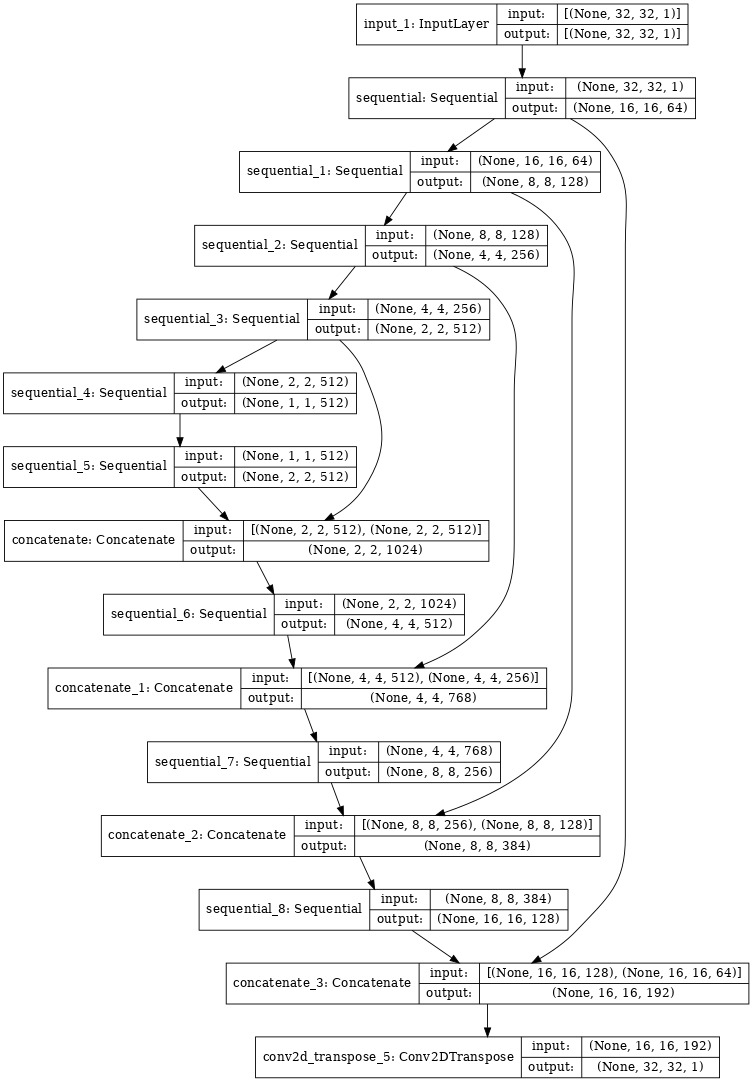

In [13]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

 Definindo a perda do gerador


In [14]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(disc_generated_output, gen_output, target,LAMBDA ):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # Erro médio absoluto
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

O procedimento de treinamento para o gerador é o seguinte:

Vamos definir o discriminador:

In [16]:
def Discriminator():

      initializer = tf.random_normal_initializer(0., 0.025)
      kernel = 2
      inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
      tar = tf.keras.layers.Input(shape=[32, 32, 1], name='target_image')

      x = tf.keras.layers.concatenate([inp, tar])  

      down1 = downsample(64,kernel,False)(x)  
      down2 = downsample(128,kernel)(down1)  
      down3 = downsample(256,kernel)(down2)  

      zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
      conv = tf.keras.layers.Conv2D(512, kernel , strides=1,
                                    kernel_initializer=initializer,
                                    use_bias=False)(zero_pad1)  

      batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

      leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

      zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

      last = tf.keras.layers.Conv2D(1, kernel , strides=2,
                                    kernel_initializer=initializer)(zero_pad2)  

      return tf.keras.Model(inputs=[inp, tar], outputs=last)

Arquitetura do modelo discriminador:

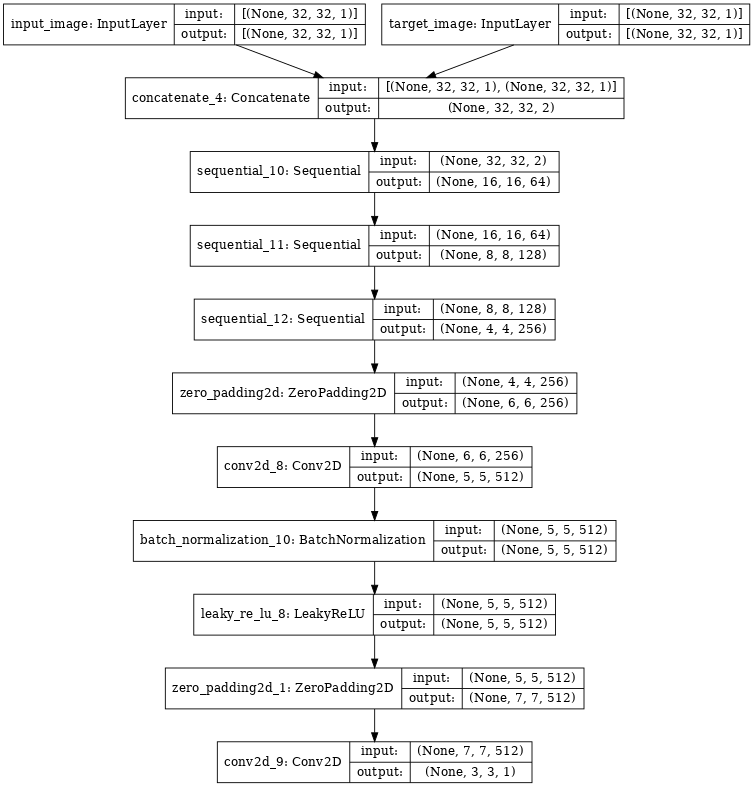

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Definindo a perda do discriminador



In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

O procedimento de treinamento para o discriminador é mostrado abaixo.


## Definindo os otimizadores e um protetor de checkpoint

In [19]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-2,
    decay_steps = 1000,
    decay_rate=0.09)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.6,clipnorm=1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.6,clipnorm=1e-3)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Gerar imagens

Escreva uma função para traçar algumas imagens durante o treinamento.

- Passe imagens do conjunto de teste para o gerador.
- O gerador irá então traduzir a imagem de entrada na saída.
- A última etapa é traçar as previsões.

In [21]:
def generate_images(model, test_input, tar,shape=(32,32), print =True):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  display_list = [np.reshape(test_input,shape), np.reshape(tar,shape), np.reshape(prediction,shape)]
  title = ['Falsa', 'Real', 'Predita']
  
  for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] ,cmap='gray')
      plt.axis('off')
  plt.show()
 

Teste a função:

2022-11-17 03:29:39.490548: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


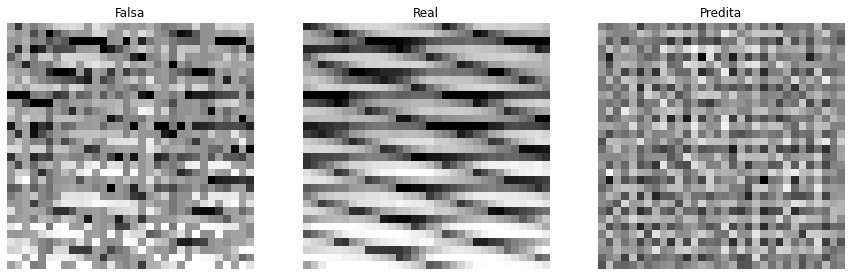

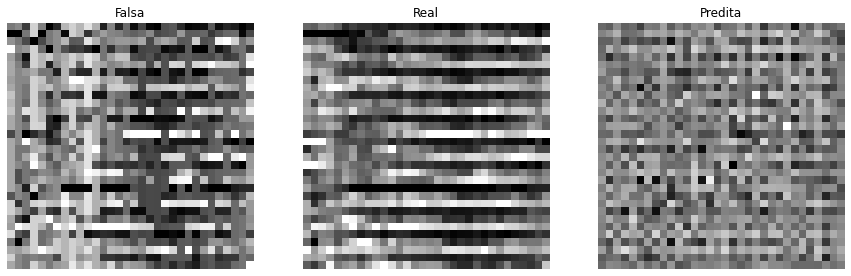

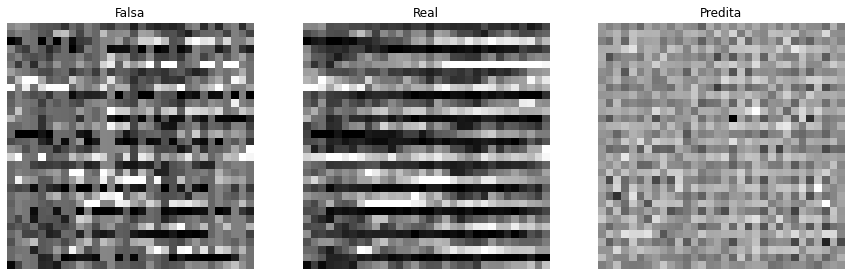

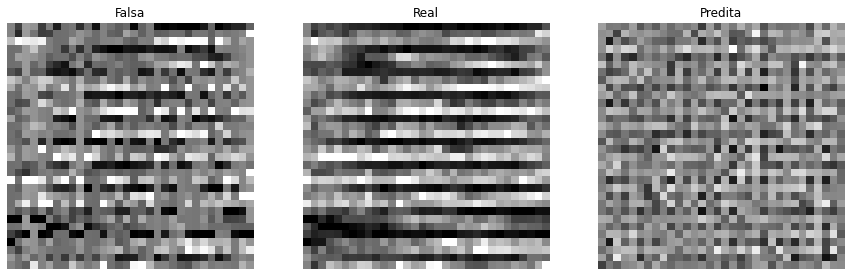

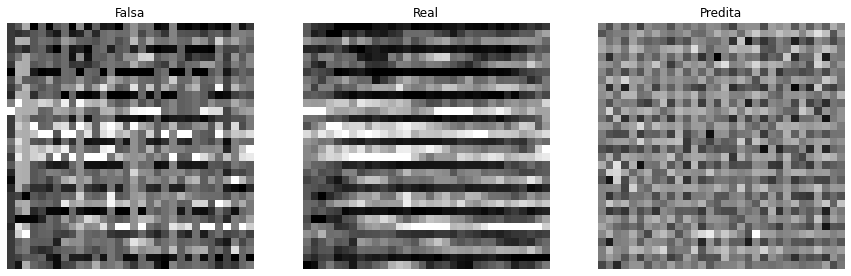

In [22]:
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)

## Treinamento

- Para cada exemplo, a entrada gera uma saída.
- O discriminador recebe `input_image` e a imagem gerada como a primeira entrada. A segunda entrada é `input_image` e` target_image`.
- Em seguida, calcula a perda do gerador e do discriminador.
- Depois, calcula os gradientes de perda em relação às variáveis ​​do gerador e do discriminador (entradas) e aplique-os ao otimizador.


In [23]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [24]:
@tf.function
def train_step(input_image, target, step,LAMBDA ):
 
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target,LAMBDA )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
      generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
      discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))
      

      with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
      

O loop de treinamento real. Como este tutorial pode executar mais de um conjunto de dados, e os conjuntos de dados variam muito em tamanho, o loop de treinamento é configurado para funcionar em etapas em vez de épocas.

- Repete o número de etapas.
- A cada 10 passos imprime uma  imagem(`.`).
- A cada 1k passos: limpa a tela e executa `generate_images` para mostrar o progresso.
- A cada 10k etapas: salve um ponto de verificação.

In [25]:
def fit(train_ds, test_ds, steps):
  LAMBDA  = 100
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()
  rmse = []
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)
     
      if step != 0:
        print(f'Tempo gasto para 1000 passos: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")
    
   
    train_step(input_image, target, step,LAMBDA )
  
   # Etapa de treinamento
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Salva checkpoint) o modelo a cada 20k etapas
    if (step + 1) % 20000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  #return rmse

Finalmente, executando o loop de treinamento:

In [26]:
#fit(train_dataset, validation_dataset, steps = 100000)

## Restaure o último ponto de verificação e teste a rede

In [27]:
# Restaurando o último ponto de verificação em checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
!ls {checkpoint_dir}

ls: cannot access './training_checkpoints': No such file or directory


## funções auxiliares e implemetnação dos métodos

In [29]:

def Smape(A, F):
    integer = 0
    for x,y in zip(A,F):
        if x==0 and y==0:
            F[integer] = 1
            A[integer] = 1
        integer+=1
            
    tmp = 1* np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    
    if len_ == 0 and np.nansum(tmp) == 0: 
        return 100
    return (100 / len(A) )* np.sum(tmp)
  

def metodos(data,n):
    _METHODS = {2: partial(pd.DataFrame.interpolate, method ='linear'),  
                3: partial(pd.DataFrame.interpolate, method = 'cubic'),
                4: partial(pd.DataFrame.interpolate, method = 'slinear'),
                5: partial(pd.DataFrame.interpolate, method = 'akima'),
                6: partial(pd.DataFrame.interpolate, method = 'polynomial', order = 5),
                7:partial(pd.DataFrame.interpolate, method = 'spline', order = 5),
                8:partial(knn, k = 4),
                9:partial(mediamovel, janela=3,minimo = 1)}
    if n == 0:
        return data.fillna(data.mean())
    if n == 1:
        return data.fillna(data.median())
    else:
        return pd.DataFrame(_METHODS[n](data))
    
def mediamovel(dado, janela , minimo = 1):
    return dado.rolling(window = janela, min_periods = minimo).mean()

def knn(dados, k):
    pos = []
    dados = pd.DataFrame(dados)  
    for i in range(dados.shape[0]):
        if mt.isnan(dados.iloc[i,0]):
            pos.append(i)
    for i in pos:
        valores = []
    
        for j in range(1, k+1,1):
            n = len(dados)
            # print(j+i)
            if i+j <= n-1:
                a = dados.iloc[i+j,0]
                if mt.isnan(a) == False:
                    valores.append(a)
            if i-j > 0:
                b = dados.iloc[i-j,0]
                if mt.isnan(b) == False :
                      valores.append(b)
                
        dados.iloc[i,0] = np.mean(valores)
          
    return dados
def index_row(lista,i):
    real = list(lista)
    real = real[::-1]
    real.append(i[:-4])
    return real[::-1]


## Reagrupar todas as as janelas em séries para aplicar os 10 métodos de imputação

In [30]:


series = np.sort(os.listdir('../input/dataset/test'))
idxts = [i[1:5] for i in series] # agrupar por série
grupo = []
for i in np.unique(idxts):
    temp = []
    for x,y in zip(series,idxts):
        if y ==i: 
            temp.append(x)
    grupo.append(temp)
   
os.mkdir('./st')
path = './st/'
for i in grupo:
    for j in i:
        if j ==i[0]:
            df = pd.read_csv('../input/dataset/test/'+j,header=None)
        else:
            df = pd.concat([df, pd.read_csv('../input/dataset/test/'+j,header=None)],axis=0)
    df.to_csv(path+j)

## Treinamento

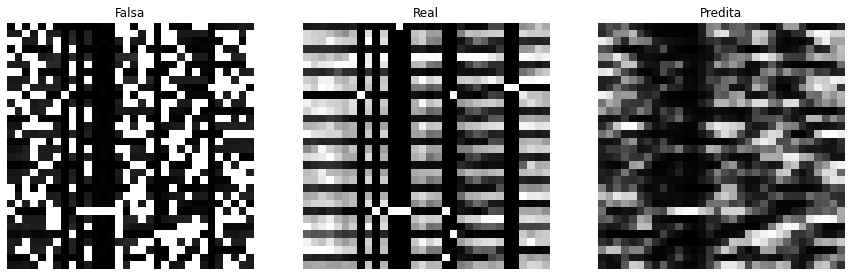

Step: 0k
......................................................................4.724414953529448


In [32]:
taxa = []
result = []

for st in range(500,2000,200):
    
    fit(train_dataset, validation_dataset, steps = st)

    smape = []
    cont = 0
    for  inp, tar  in test_dataset.take(-1):
        prediction = generator(inp, training=True)
        
        b = np.reshape(prediction,(32,32))
        tar = np.reshape(tar,(32,32))
        inp = np.reshape(inp,(32,32))
        
        b = b*lista_inp[cont][0] + lista_inp[cont][1]
        tar = tar*lista[cont][0]+lista[cont][1]
        inp = inp*lista_inp[cont][0]+lista_inp[cont][1]
            
            
        b = np.reshape(b,(32*32))
        tar = np.reshape(tar,(32*32))
        inp = np.reshape(inp,(32*32))
        index =  np.argwhere(tar!=inp)
        smape.append(Smape(tar[index],b[index]))
        cont+=1
    result.append([np.mean(smape),st])#verificar aprendizado
    
    print(np.mean(smape))
    #aqui procurarmos os melhores resultados baseados no mínimo de alguns experimentos

    if np.mean(smape)<4.725:

        os.mkdir('./sets')
        nomes = ['media','mediana','inter_linear','inter_cubic','inter_slinear',
                 'inter_akima','inter_poly5','inter_spline5','knn','media_movel_3']
       
        smape = []
        cont = 0
        for  inp, tar  in test_dataset.take(-1):
            
            b = np.reshape(prediction,(32,32))
            tar = np.reshape(tar,(32,32))
            inp = np.reshape(inp,(32,32))

            b = b*lista_inp[cont][0] + lista_inp[cont][1]
            tar = tar*lista[cont][0]+lista[cont][1]
            inp = inp*lista_inp[cont][0]+lista_inp[cont][1]


            b = np.reshape(b,(32*32))
            tar = np.reshape(tar,(32*32))
            inp = np.reshape(inp,(32*32))
            index =  np.argwhere(tar!=inp)
            index = np.concatenate(index)
            smape.append(Smape(tar[index],b[index]))
            data = pd.DataFrame([],columns=nomes)
            data['real'] = tar[index]
            data['pix'] = b[index]
    
            data.to_csv('./sets/'+'_'+t[cont])
    
            cont+=1
        break    

## Reagrupar janelas em uma mesma série

In [34]:
series= os.listdir('./sets')
idxts = [i[1:5] for i in series] # agrupar por série
grupo = []
for i in np.unique(idxts):
    temp = []
    for x,y in zip(series,idxts):
        if y ==i: 
            temp.append(x)
    grupo.append(temp)
   
os.mkdir('./pordataset')
path = './pordataset/'
for i in grupo:
    for j in i:
        if j ==i[0]:
            df = pd.read_csv('./sets/'+j,index_col=0)
        else:
            df = pd.concat([df,pd.read_csv('./sets/'+j,index_col = 0)],axis=0)
    df.to_csv(path+j[1:])


## Imputação usando métodos consagrados

In [35]:
#Essa celula pode demorar um pouco a ser executa devido a imputção por splines
for x, y in zip(np.sort(os.listdir('./st')),np.sort(os.listdir('./pordataset'))):
    print(x)
    df1 = pd.read_csv('./st/'+x,index_col=0).to_numpy()
    w = df1.shape[1]
    w = w // 2
    ts_fake = df1[:, w:]
    ts_fake = np.reshape(ts_fake,(ts_fake.shape[0]*ts_fake.shape[1],))
                         
    ts_real = df1[:, :w]
    ts_real = np.reshape(ts_real,(ts_real.shape[0]*ts_real.shape[1],))
    
    index =  np.argwhere(ts_fake != ts_real )
    index = np.concatenate(index)
    
    data = pd.read_csv('./pordataset/'+y,index_col=0)
    for s in range(10):  
           ts_fake[index] = np.nan 
           dat = metodos(pd.DataFrame(ts_fake ), s)
           data[nomes[s]] = dat.iloc[index,-1] # alguns métodos retonam uma coluna cópia
    data.to_csv('./pordataset/'+y)
    

Birmingham Parking2.csv
LD2011_2014_828.csv
Return_Temperature2.csv
bike_sharing7.csv
daily_minimum_temperatures_in_me2.csv
manchasol2.csv


## amazenar quantidade de valores não imputados e removê-los

In [36]:

data_falta = pd.DataFrame([],index=np.unique(idxts),columns = data.columns )
cont = 0
for i in os.listdir('./pordataset/'):
    df = pd.read_csv('./pordataset/'+i,index_col=0)
    data_falta.iloc[cont,:] = df.isnull().sum().values
    df.dropna(inplace=True,axis=0)
    df.to_csv('./pordataset/'+i)
    cont+=1

In [37]:
#visualizar quantidade por método e série. 'real' são os valores reaais de cada série
data_falta.drop(['real'],axis=1).head()

,media,mediana,inter_linear,inter_cubic,inter_slinear,inter_akima,inter_poly5,inter_spline5,knn,media_movel_3,pix
Birm,150428,150428,150428,150428,150428,150428,150428,150428,150428,165936,0
LD20,476,476,476,476,476,476,476,476,476,521,0
Retu,1855,1855,1855,1855,1855,1855,1855,1855,1855,2035,0
bike,473,473,473,473,473,473,473,473,473,509,0
dail,1900,1900,1900,1900,1900,1900,1900,1900,1900,2073,0


<AxesSubplot:>

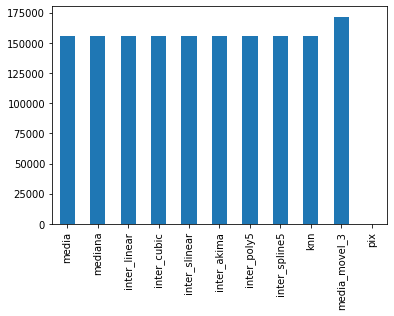

In [38]:
#visualização gráfica
data_falta.drop(['real'],axis=1).sum().plot(kind='bar')

# Calcular métricas 

In [39]:

new = ['M', 'MD', 'IL', 'IC', 'IS', 'IA' ,'IP5' ,'IPS5', '4-nn', 'MV3', 'pix2pix']
nomes = ['media','mediana','inter_linear','inter_cubic','inter_slinear',
                 'inter_akima','inter_poly5','inter_spline5','knn','media_movel_3','pix']
sets = os.listdir('./pordataset/')

from sklearn.metrics import mean_squared_error as rmse,median_absolute_error as mae


for mtr in ['mae','rmse','asmape']:
    metricas  = pd.DataFrame([],index=[i[:-5] for i in sets],columns=new)
    for k in range(6):
        df = pd.read_csv('./pordataset/'+sets[k],index_col = 0)
        for i,j  in zip (new,nomes):      
                r = df['real'].values
                m = df[j].values
                if mtr=='mae':
                    metricas[i][k] = mae(r,m).round(3)
                
                if mtr =='rmse':
                    metricas[i][k] = rmse(r,m,squared=False).round(3)
                    
                if mtr =='asmape' :
                    metricas[i][k]= Smape(r, m).round(3)
        metricas.set_axis(new,axis=1,inplace=True)
        metricas.to_csv(mtr+'.csv')    
        

In [40]:
df = pd.read_csv('./asmape.csv',index_col=0)

In [41]:
#visualizar ASMAPE
df.head(10)

,M,MD,IL,IC,IS,IA,IP5,IPS5,4-nn,MV3,pix2pix
LD2011_2014_228,37.757,34.512,41.352,41.505,41.352,41.414,41.702,41.627,41.189,41.360,15.370
daily_minimum_temperatures_in_me,15.021,14.964,23.126,24.566,23.126,23.456,27.010,24.287,22.113,24.057,8.818
Return_Temperature1,12.065,11.784,16.759,16.831,16.759,16.808,16.862,16.776,16.641,17.059,14.333
manchasol,15.056,15.004,23.950,25.477,23.950,24.334,27.046,25.598,22.466,24.844,8.768
bike_sharing,37.971,38.677,49.878,54.114,49.878,52.203,55.368,55.549,45.117,52.550,44.235
Birmingham Parking,16.450,16.447,21.364,22.798,21.364,21.748,23.411,23.409,19.528,23.145,22.725


In [42]:
#zipar para baixar
from zipfile import ZipFile
from os.path import basename
# create a ZipFile object
with ZipFile('./pordata.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('./pordataset'):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))
        
with ZipFile('./sets.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('./sets'):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))